# Gesture Recognition
We want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 - Thumbs up:  Increase the volume
 - Thumbs down: Decrease the volume
 - Left swipe: 'Jump' backwards 10 seconds
 - Right swipe: 'Jump' forward 10 seconds  
 - Stop: Pause the movie
 
In this project, you are going to build a RNN model that will be able to predict the 5 hand gestures correctly, to control a smart tv.

## About Dataset
Dataset contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 

Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

In [1]:
!pip install --upgrade pip

     |████████████████████████████████| 1.6 MB 5.2 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.1.2
    Uninstalling pip-21.1.2:
      Successfully uninstalled pip-21.1.2


In [2]:
!pip install mediapipe

     |████████████████████████████████| 32.2 MB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 56.1 MB 45 kB/s s eta 0:00:01


In [3]:
!nvidia-smi

Tue Aug 10 02:09:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:41:00.0 Off |                    0 |
| N/A   31C    P0    35W / 250W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import random as rn
from tensorflow import keras
import tensorflow as tf
import cv2
import mediapipe as mp
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/dataset/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/dataset/Project_data/val.csv').readlines())
train_path = '/home/dataset/Project_data/train'
val_path = '/home/dataset/Project_data/val'
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Function for localization

In [7]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

def get_localized_image(image):
    return_image = image
    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=1,
        min_detection_confidence=0.5) as hands:
        
        image = cv2.flip(image, 1)
        results = hands.process(image)
        if results.multi_hand_landmarks:
            annotated_image = image.copy()
            h, w, c = image.shape
            X_fix = 20
            Y_fix = 30
            x_max = 0
            y_max = 0
            x_min = w
            y_min = h
            for handLMs in results.multi_hand_landmarks:
                for lm in handLMs.landmark:
                    x, y = int(lm.x * w), int(lm.y * h)
                    if x > x_max:
                        x_max = x
                        x_max += X_fix
                        if x_max > w:
                            x_max = w
                    if x < x_min:
                        x_min = x
                        x_min -= X_fix
                        if x_min < 0:
                            x_min = 0
                    if y > y_max:
                        y_max = y
                        y_max += Y_fix
                        if y_max > h:
                            y_max = h
                    if y < y_min:
                        y_min = y
                        y_min -= Y_fix
                        if y_min < 0:
                            y_min = 0
            annotated_image = cv2.rectangle(annotated_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)
            mp_drawing.draw_landmarks(annotated_image, handLMs, mp_hands.HAND_CONNECTIONS)
            return_image = cv2.flip(annotated_image, 1)
    return return_image

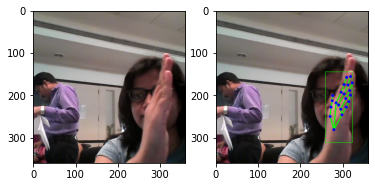

In [8]:
import matplotlib.pyplot as plt
image1 = imread('/home/dataset/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00032.png')
plt.subplot(1,2, 1)
plt.imshow(image1)
image1 = get_localized_image(image1)
plt.subplot(1,2, 2)
plt.imshow(image1)
plt.show()

### Using above localization algorithm, From existring dataset (train & val), I have created new datasets - "train_loc" & "val_loc", for training and validation purpose.

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)
                  
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [5]:
batch_size = 64
num_epochs = 30
steps_per_epoch = int(num_train_sequences/batch_size)
validation_steps = int(num_val_sequences/batch_size)
if (num_train_sequences%batch_size) != 0:
    steps_per_epoch += 1
if (num_val_sequences%batch_size) != 0:
    validation_steps += 1 

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Model - 1
batch=64
epochs=30
image_size=120*120
optimizer=SGD (lr= 0.001)

### Transfer learning + CNN + RNN:
[VGG16 (imagenet) --> FLatten --> Dropout(0.5) --> Dense(64)] --> [TimeDistributed --> GRU(32) --> GRU(16) --> Dropout(0.5) -->Dense(8)] --> softmax(5) 

In [6]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 64)            15009664  
_________________________________________________________________
gru (GRU)                    (None, 15, 32)            9408      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 45        
Total params: 15,021,653
Trainable params: 306,965
Non-trainable params: 14,714,688
______________________________________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
## Add model callbacks_list
# model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [16]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/dataset/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - 56s 4s/step - loss: 1.6994 - categorical_accuracy: 0.1810 - val_loss: 1.6465 - val_categorical_accuracy: 0.2200
Epoch 2/30
11/11 [==============================] - 41s 4s/step - loss: 1.6628 - categorical_accuracy: 0.2036 - val_loss: 1.6151 - val_categorical_accuracy: 0.2300
Epoch 3/30
11/11 [==============================] - 41s 4s/step - loss: 1.6449 - categorical_accuracy: 0.2097 - val_loss: 1.5920 - val_categorical_accuracy: 0.2100
Epoch 4/30
11/11 [==============================] - 40s 4s/step - loss: 1.6639 - categorical_accuracy: 0.2127 - val_loss: 1.6051 - val_categorical_accuracy: 0.1900
Epoch 5/30
11/11 [==============================] - 42s 4s/step - loss: 1.6465 - categorical_accuracy: 0.2202 - val_loss: 1.5891 - val_categorical_accuracy: 0.2200
Epoch 6/30
11/11 [==============================] - 39s 4s/step - loss: 1.6449 - categorical_accuracy: 0.2127 - va

### Model - 1 : Summary
We can see that, Accuracy is reached to ~40% after 30 epochs. And We dont see any overfiiting till now.
But accuracy is very low. So we need to change our model.

# Model - 2
batch=64
epochs=30
image_size=120*120
optimizer=ADAM(lr= 0.001)

### Transfer learning + CNN + RNN:
[VGG16 (imagenet) --> FLatten -->  Dense(128) ---> Dropout(0.5) --> Dense(64)] --> [TimeDistributed --> GRU(32) --> GRU(16) --> Dropout(0.5) -->  Dense(16) --> Dense(8)] --> softmax(5) 

In [17]:
batch_size = 64
num_epochs = 30
steps_per_epoch = int(num_train_sequences/batch_size)
validation_steps = int(num_val_sequences/batch_size)
if (num_train_sequences%batch_size) != 0:
    steps_per_epoch += 1
if (num_val_sequences%batch_size) != 0:
    validation_steps += 1
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 15, 64)            15312896  
_________________________________________________________________
gru_4 (GRU)                  (None, 15, 32)            9408      
_________________________________________________________________
gru_5 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                

In [20]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/dataset/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - 44s 4s/step - loss: 1.6195 - categorical_accuracy: 0.2398 - val_loss: 1.5596 - val_categorical_accuracy: 0.2900
Epoch 2/30
11/11 [==============================] - 40s 4s/step - loss: 1.5625 - categorical_accuracy: 0.2836 - val_loss: 1.5645 - val_categorical_accuracy: 0.3500
Epoch 3/30
11/11 [==============================] - 41s 4s/step - loss: 1.5407 - categorical_accuracy: 0.2790 - val_loss: 1.5055 - val_categorical_accuracy: 0.3100
Epoch 4/30
11/11 [==============================] - 40s 4s/step - loss: 1.5409 - categorical_accuracy: 0.2821 - val_loss: 1.5134 - val_categorical_accuracy: 0.2900
Epoch 5/30
11/11 [==============================] - 41s 4s/step - loss: 1.4974 - categorical_accuracy: 0.3213 - val_loss: 1.4530 - val_categorical_accuracy: 0.3500
Epoch 6/30
11/11 [==============================] - 39s 4s/step - loss: 1.4569 - categorical_accuracy: 0.3544 - va

### Model -2 : Summary
Overfitting - We can see good accuracy now, but model is getiing overfit.

# Model - 3
batch=64
epochs=30
image_size=120*120
optimizer=ADAM(lr= 0.001)

### Transfer learning + CNN + RNN:
[VGG19 (imagenet) --> FLatten -->  Dense(128) ---> Dropout(0.5) --> Dense(64)] --> [TimeDistributed --> GRU(32) --> GRU(16) --> Dropout(0.5) -->  Dense(16) --> Dense(8)] --> softmax(5) 

In [22]:
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 15, 64)            20622592  
_________________________________________________________________
gru_8 (GRU)                  (None, 15, 64)            24960     
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                

In [23]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
11/11 [==============================] - 44s 4s/step - loss: 1.7960 - categorical_accuracy: 0.2036 - val_loss: 1.5665 - val_categorical_accuracy: 0.2900
Epoch 2/30
11/11 [==============================] - 40s 4s/step - loss: 1.6199 - categorical_accuracy: 0.2564 - val_loss: 1.5073 - val_categorical_accuracy: 0.3200
Epoch 3/30
11/11 [==============================] - 39s 4s/step - loss: 1.5976 - categorical_accuracy: 0.2262 - val_loss: 1.5155 - val_categorical_accuracy: 0.3900
Epoch 4/30
11/11 [==============================] - 40s 4s/step - loss: 1.5438 - categorical_accuracy: 0.2896 - val_loss: 1.4474 - val_categorical_accuracy: 0.3200
Epoch 5/30
11/11 [==============================] - 40s 4s/step - loss: 1.4808 - categorical_accuracy: 0.3167 - val_loss: 1.3430 - val_categorical_accuracy: 0.4900
Epoch 6/30
11/11 [==============================] - 40s 4s/step - loss: 1.3975 - categorical_accuracy: 0.3348 - val_loss: 1.2614 - val_categorical_accuracy: 0.5000
Epoch 7/30
11/11

### Model - 3 : Summary
Overfitting issue resolved and accuracy is also decent. Lets try to inrease the epoch to increase the accuracy

# Model - 4
batch=64
epochs=50
image_size=120*120
optimizer=ADAM(lr= 0.001)

### Transfer learning + CNN + RNN:
[VGG19 (imagenet) --> FLatten -->  Dense(128) ---> Dropout(0.5) --> Dense(64)] --> [TimeDistributed --> GRU(32) --> GRU(16) --> Dropout(0.5) -->  Dense(16) --> Dense(8)] --> softmax(5) 

In [25]:
batch_size = 64
num_epochs = 50
steps_per_epoch = int(num_train_sequences/batch_size)
validation_steps = int(num_val_sequences/batch_size)
if (num_train_sequences%batch_size) != 0:
    steps_per_epoch += 1
if (num_val_sequences%batch_size) != 0:
    validation_steps += 1
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [26]:
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 15, 64)            20622592  
_________________________________________________________________
gru_10 (GRU)                 (None, 15, 64)            24960     
_________________________________________________________________
gru_11 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_14 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 5)                

In [27]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/dataset/Project_data/train ; batch size = 64
Epoch 1/50
11/11 [==============================] - 44s 4s/step - loss: 1.7739 - categorical_accuracy: 0.2308 - val_loss: 1.5483 - val_categorical_accuracy: 0.3000
Epoch 2/50
11/11 [==============================] - 40s 4s/step - loss: 1.6253 - categorical_accuracy: 0.2262 - val_loss: 1.5499 - val_categorical_accuracy: 0.3000
Epoch 3/50
11/11 [==============================] - 42s 4s/step - loss: 1.5978 - categorical_accuracy: 0.2670 - val_loss: 1.5210 - val_categorical_accuracy: 0.4400
Epoch 4/50
11/11 [==============================] - 40s 4s/step - loss: 1.5366 - categorical_accuracy: 0.3032 - val_loss: 1.4232 - val_categorical_accuracy: 0.5100
Epoch 5/50
11/11 [==============================] - 41s 4s/step - loss: 1.4651 - categorical_accuracy: 0.3695 - val_loss: 1.3044 - val_categorical_accuracy: 0.6200
Epoch 6/50
11/11 [==============================] - 40s 4s/step - loss: 1.3470 - categorical_accuracy: 0.4133 - va

### Model - 4 : Summary
No such overfitting and accuracy is also about ~90%.

In [28]:
model.save("models/gesture_recognition_vgg19.h5")

In [29]:
#model = keras.models.load_model("models/gesture_recognition_vgg19.h5")

In [31]:
train_path = '/home/dataset/Project_data/train_loc'
val_path = '/home/dataset/Project_data/val_loc'

# Model - 5
batch=64
epochs=50
image_size=120*120
optimizer=ADAM(lr= 0.001)

### Image Localization + Transfer learning + CNN + RNN:
[VGG19 (imagenet) --> FLatten -->  Dense(128) ---> Dropout(0.5) --> Dense(64)] --> [TimeDistributed --> GRU(32) --> GRU(16) --> Dropout(0.5) -->  Dense(16) --> Dense(8)] --> softmax(5) 

In [10]:
batch_size = 64
num_epochs = 50
steps_per_epoch = int(num_train_sequences/batch_size)
validation_steps = int(num_val_sequences/batch_size)
if (num_train_sequences%batch_size) != 0:
    steps_per_epoch += 1
if (num_val_sequences%batch_size) != 0:
    validation_steps += 1
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

adam = optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 64)            20622592  
_________________________________________________________________
gru_2 (GRU)                  (None, 15, 64)            24960     
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                

In [12]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/dataset/Project_data/train ; batch size = 64
Epoch 1/50
11/11 [==============================] - 56s 4s/step - loss: 1.7611 - categorical_accuracy: 0.2232 - val_loss: 1.5972 - val_categorical_accuracy: 0.2100
Epoch 2/50
11/11 [==============================] - 41s 4s/step - loss: 1.6530 - categorical_accuracy: 0.2278 - val_loss: 1.5578 - val_categorical_accuracy: 0.2800
Epoch 3/50
11/11 [==============================] - 41s 4s/step - loss: 1.6317 - categorical_accuracy: 0.2338 - val_loss: 1.5556 - val_categorical_accuracy: 0.2600
Epoch 4/50
11/11 [==============================] - 40s 4s/step - loss: 1.5959 - categorical_accuracy: 0.2443 - val_loss: 1.5052 - val_categorical_accuracy: 0.3400
Epoch 5/50
11/11 [==============================] - 42s 4s/step - loss: 1.5798 - categorical_accuracy: 0.2459 - val_loss: 1.5160 - val_categorical_accuracy: 0.3700
Epoch 6/50
11/11 [==============================] - 39s 4s/step - loss: 1.5501 - categorical_accuracy: 0.2790 - va

In [13]:
model.save("models/gesture_recognition_vgg19_localization.h5")

### We are able to get almost ~90% accuracy, to classify the gestures.

# Thank You !!